## 1. Load Dependencies & Dataset:

In [36]:
# Import data processing and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

# Import feature engineering libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from hyperopt import hp, tpe, fmin, Trials, space_eval

# Import performance metrics libraries
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

# Import classifcation libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

In [15]:
# Load the dataset
data = pd.read_csv("") # add path to datafile 

# Create a copy of the dataset
df = data.copy()

# Define the target variable
TARGET = "Transaction"

## 2. Initial Inspection:

In [3]:
# Get a brief overview about the columns and data types:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12205 entries, 0 to 12204
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction         12205 non-null  int64  
 1   Customer_Type       12205 non-null  object 
 2   SystemF1            12205 non-null  int64  
 3   SystemF2            12205 non-null  int64  
 4   SystemF3            12205 non-null  int64  
 5   SystemF4            12205 non-null  int64  
 6   SystemF5            12205 non-null  int64  
 7   Account_Page        12205 non-null  int64  
 8   Account_Page_Time   12205 non-null  float64
 9   Info_Page           12205 non-null  int64  
 10  Info_Page_Time      12205 non-null  float64
 11  ProductPage         12205 non-null  int64  
 12  ProductPage_Time    12205 non-null  float64
 13  Month               12205 non-null  int64  
 14  Weekday             12205 non-null  bool   
 15  SpecificHoliday     12205 non-null  float64
 16  Goog

In [8]:
# Check dataframe for NA & duplicate values:
print(f"The dataframe contains {np.sum(df.isna().sum())} NA values.")
print(f"The dataframe contains {df.duplicated().sum()} duplicates.")

The dataframe contains 0 NA values.
The dataframe contains 0 duplicate values.


In [9]:
# Descriptive Statistics Overview:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction,12205.0,0.156329,0.363182,0.0,0.000000,0.000000,0.000000,1.000000
SystemF1,12205.0,2.124211,0.906823,1.0,2.000000,2.000000,3.000000,8.000000
SystemF2,12205.0,2.357804,1.710114,1.0,2.000000,2.000000,2.000000,13.000000
SystemF3,12205.0,3.153298,2.402340,1.0,1.000000,3.000000,4.000000,9.000000
SystemF4,12205.0,4.073904,4.016654,1.0,2.000000,2.000000,4.000000,20.000000
SystemF5,12205.0,3.003687,1.409130,1.0,2.000000,3.000000,4.000000,5.000000
Account_Page,12205.0,2.338878,3.330436,0.0,0.000000,1.000000,4.000000,27.000000
Account_Page_Time,12205.0,81.646331,177.491845,0.0,0.000000,9.000000,94.700000,3398.750000
Info_Page,12205.0,0.508726,1.275617,0.0,0.000000,0.000000,0.000000,24.000000
Info_Page_Time,12205.0,34.825454,141.424807,0.0,0.000000,0.000000,0.000000,2549.375000


Interpretation:
* The target variable `Transaction` needs conversion into a categorical variable and will undergo further examination during the EDA.
* `SystemF2` & `SystemF3` exhibit mean values relatively close to the median, suggesting a fairly symmetric distribution. However, these variables contain significant outliers, as the maximum value exceeds the 75th percentile by a notable margin.
* `SystemF4` demonstrates a higher mean than the median, indicating a right-skewed distribution. Additionally, the presence of outliers is suggested by a significantly higher maximum value compared to the 75th percentile.
* `Account_Page`, `Info_Page`, `ProductPage`, `Account_Page_Time`, `Info_Page_Time`, and `ProductPage_Time` show extreme outliers with maximum values significantly higher than the 75th percentile. These variables also display right skewness, with the mean notably higher than the median.
* Further investigation is required for `GoogleAnalytics_BR`, `GoogleAnalytics_ER`, and `GoogleAnalytics_PV`. Consider binning and categorizing these variables.
* `Ad_Campaign_1`, `Ad_Campaign_2`, and `Ad_Campaign_3` can be converted into categorical variables.

## 2. EDA:

In [19]:
# Function to create bar chart
def plot_bar_chart(dataframe, discrete_columns):
    """
    Plots count plots for the specified discrete columns in the provided DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The DataFrame containing the data.
    discrete_columns (list of str): The names of the discrete columns to be visualized.
    """
    num_plots = len(discrete_columns)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 4))

    if num_plots == 1:
        axes = [axes]  

    color = '#4374B3'

    for index, column in enumerate(discrete_columns):
        sns.countplot(data=dataframe, x=column, ax=axes[index],  color=color)
        axes[index].set_title(f"Countplot of {column}")
        axes[index].set_xlabel(column)

    plt.tight_layout()
    plt.show()

# Function to create boxplot
def generate_boxplot(dataframe, columns):
    """

    Plots a series of boxplots.

    Parameters:
    dataframe : pandas DataFrame
        The DataFrame containing the data.
    columns : list
        A list of column names to be plotted.

    Returns:
    None
    """

    color = '#4374B3'


    sns.boxplot(data=dataframe[columns], color=color)

# Function to create histogram
def plot_hist_chart(dataframe, discrete_columns):
    """
    Plots histograms for the specified discrete columns in the provided DataFrame using Seaborn.

    Parameters:
    dataframe (pandas.DataFrame): The DataFrame containing the data.
    discrete_columns (list of str): The names of the discrete columns to be visualized.
    """
    num_plots = len(discrete_columns)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 4))

    if num_plots == 1:
        axes = [axes]  

    for index, column in enumerate(discrete_columns):
        sns.histplot(data=dataframe[column], ax=axes[index], kde=True, bins=85)
        axes[index].set_title(f"Histogram of {column}")
        axes[index].set_xlabel(column)

    plt.tight_layout()
    plt.show()

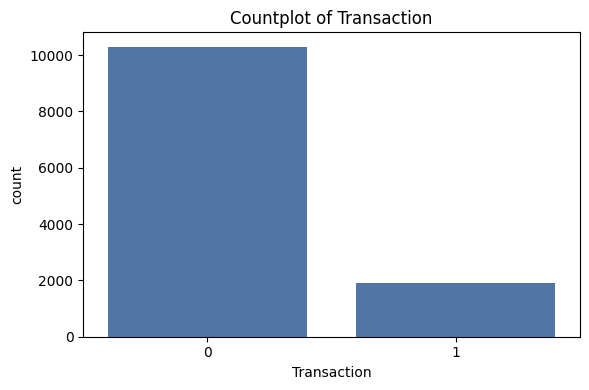

In [18]:
# Visualize the dependent variable
plot_bar_chart(df, ['Transaction'])

Interpretation:
* The chart above clearly indicates an imbalance in the target variable, suggesting the need for an oversampling approach.
* Undersampling is deemed inappropriate in this scenario due to the limited size of the dataset.

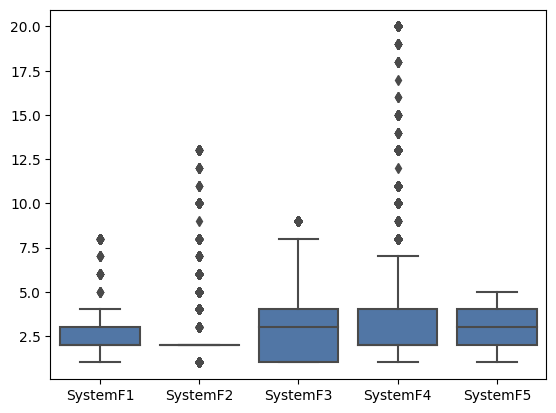

In [7]:
# Visualize SystemF1 to SystemF5 variables
generate_boxplot(df, ['SystemF1', 'SystemF2', 'SystemF3', 'SystemF4', 'SystemF5'])

Interpretation:
* The boxplots above indicate outliers for all variables except SystemF5.
* Additionally, all variables exhibit skewness except for SystemF5.

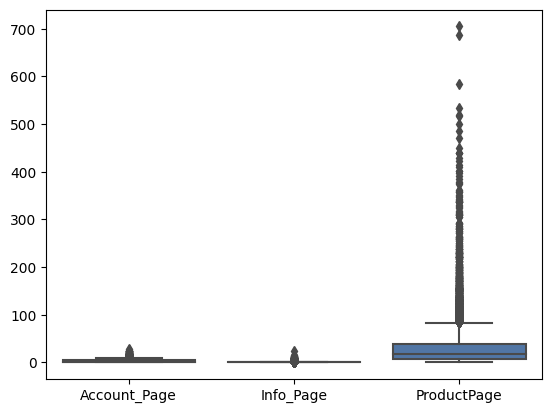

In [10]:
# Visualize page click frequency variables 
generate_boxplot(df, ['Account_Page', 'Info_Page', 'ProductPage'])

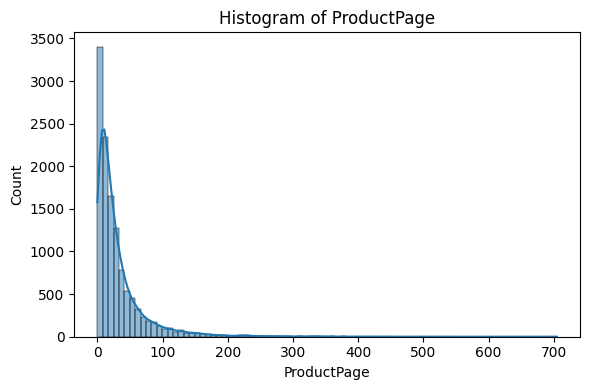

In [23]:
# Visualize distribution of ProducPage
plot_hist_chart(df, ['ProductPage'])

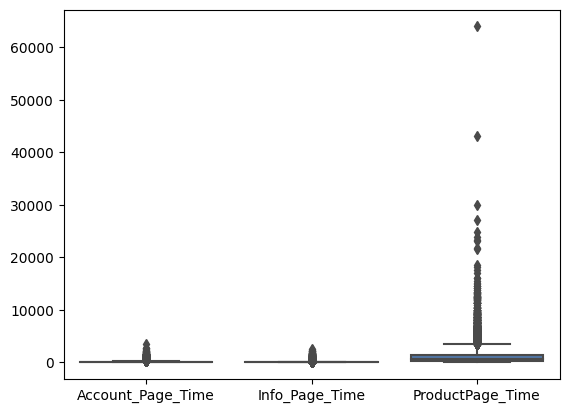

In [24]:
# Visualize the time spend on different variables
generate_boxplot(df, ['Account_Page_Time', 'Info_Page_Time', 'ProductPage_Time'])

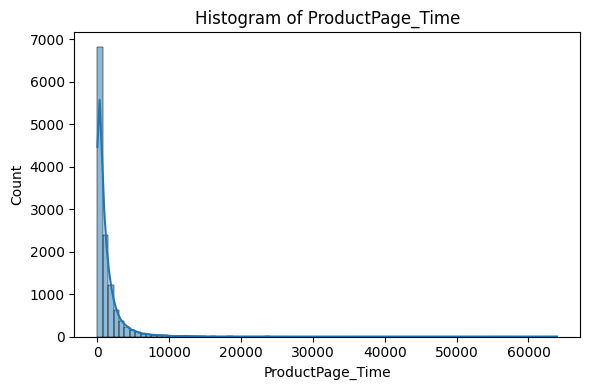

In [25]:
# Visualize distribution of ProductPage_Time
plot_hist_chart(df, ['ProductPage_Time'])

Interpretation
* The `ProductPage` attracts significantly more visitors compared to other pages. Additionally, visitors spend notably more time (`ProductPage_Time`) on the `ProductPage` than on other pages.
* All variables exhibit high skewness and contain numerous outliers.

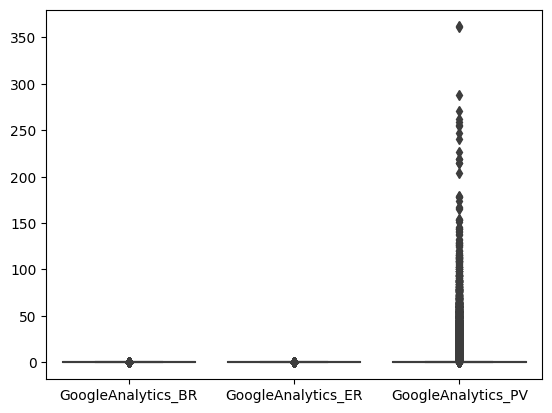

In [79]:
# Visualize the google analytics metrics
generate_boxplot(df, ['GoogleAnalytics_BR', 'GoogleAnalytics_ER', 'GoogleAnalytics_PV'])

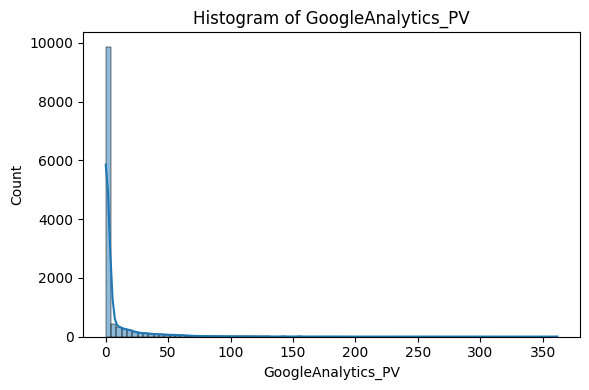

In [27]:
plot_hist_chart(df, ['GoogleAnalytics_PV'])

Interpretation
* The boxplots show that the website visitors are not leaving the site upon arrival, which is positive (`GoogleAnalytics_BR`). However, the relative low `GoogleAnalytics_ER` suggests that the visitors are not extensively interacting with the website either. This could mean that visitors find simple and quick (i.e., low `GoogleAnalytics_PV`) relevant content on the website. This is also reflected by the `ProductPage_Time` data above that visitors spend more time on the product page.
* From a technical perspective all three variables (`GoogleAnalytics_ER`, `GoogleAnalytics_BR`, `GoogleAnalytics_PV`) exhibit skeweness and outliers, which in particular for the `GoogleAnalytics_PV` variable significantly affects the mean value. 

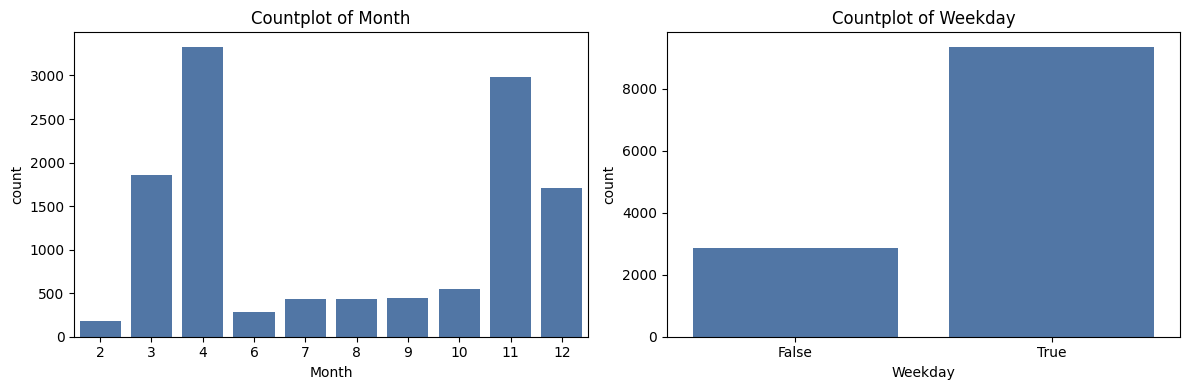

In [29]:
# Visualize the temporal features
plot_bar_chart(df, ['Month', 'Weekday'])

Interpretation
* The bar chart representing the `Month` feature indicates a noticeable seasonal pattern in user behavior, showing increased website visitors during winter and early spring months.
* Additionally, the `Weekday` feature highlights predominant website visits occurring during weekdays.

### 3. Outlier Treatment

In [30]:
def replace_outliers(df: pd.DataFrame, inner_fence_multiplier: float = 1.5, outer_fence_multiplier: float = 3.0) -> pd.DataFrame:
    """
    Function used to replace outliers in each continuous column with the mean value.

    Parameters:
        - df (pd.DataFrame): A DataFrame containing the data.
        - inner_fence_multiplier (float): A multiplier to determine the inner fence. Default is 1.5.
        - outer_fence_multiplier (float): A multiplier to determine the outer fence. Default is 3.0.

    Returns:
        - df (pd.DataFrame): A DataFrame with outliers replaced by the mean value.
    """

    for column in ['SystemF2', 'SystemF4', 'Account_Page', 'Account_Page_Time', 'Info_Page', 'Info_Page_Time', 'ProductPage', 'ProductPage_Time', 'GoogleAnalytics_BR', 'GoogleAnalytics_ER', 'GoogleAnalytics_PV']:
        # Calculate the Interquartile Range (IQR)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate the inner and outer fences
        inner_fence_low = Q1 - inner_fence_multiplier * IQR
        inner_fence_high = Q3 + inner_fence_multiplier * IQR
        outer_fence_low = Q1 - outer_fence_multiplier * IQR
        outer_fence_high = Q3 + outer_fence_multiplier * IQR

        # Identify the outliers using the inner and outer fences
        outliers = (df[column] < inner_fence_low) | (df[column] > inner_fence_high) | \
                   (df[column] < outer_fence_low) | (df[column] > outer_fence_high)

        # Replace the outliers with the mean value
        df.loc[outliers, column] = df[column].mean()


    return df

In [31]:
# Apply the replace_outliers function to the datasets
df = replace_outliers(df)

Interpretation:
* Following the exploratory data analysis (EDA), we determined to replace outliers with the mean value of each column using the `replace_outliers` function. This step aims to minimize the influence of outliers on the predictions.

### 4. Data Preparation

In [32]:
# Define the label enconder
label_encoder = LabelEncoder()

# Columns for label encoding
label_columns = ["Weekday", "Customer_Type"]

# Apply the label encoder
df[label_columns] = df[label_columns].apply(label_encoder.fit_transform)

In [33]:
# Split the dataset into X and y, representing the features and the target variable
X = df.drop(columns=[TARGET], axis=1)
y = df[TARGET]

# Prespecify the random state
RANDOM_STATE = 2

# Define the oversampler
oversampler = RandomOverSampler(random_state=RANDOM_STATE)

# Oversample the minority class
X, y = oversampler.fit_resample(X, y)

In [34]:
# Perform a train-test split on the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

# Define the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the validation and testing data
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Transform the arrays to DataFrames
X_train = pd.DataFrame(X_train, columns=X.columns)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test, columns=X.columns)
X_valid = pd.DataFrame(X_valid, columns=X.columns)

### 5. Model Building

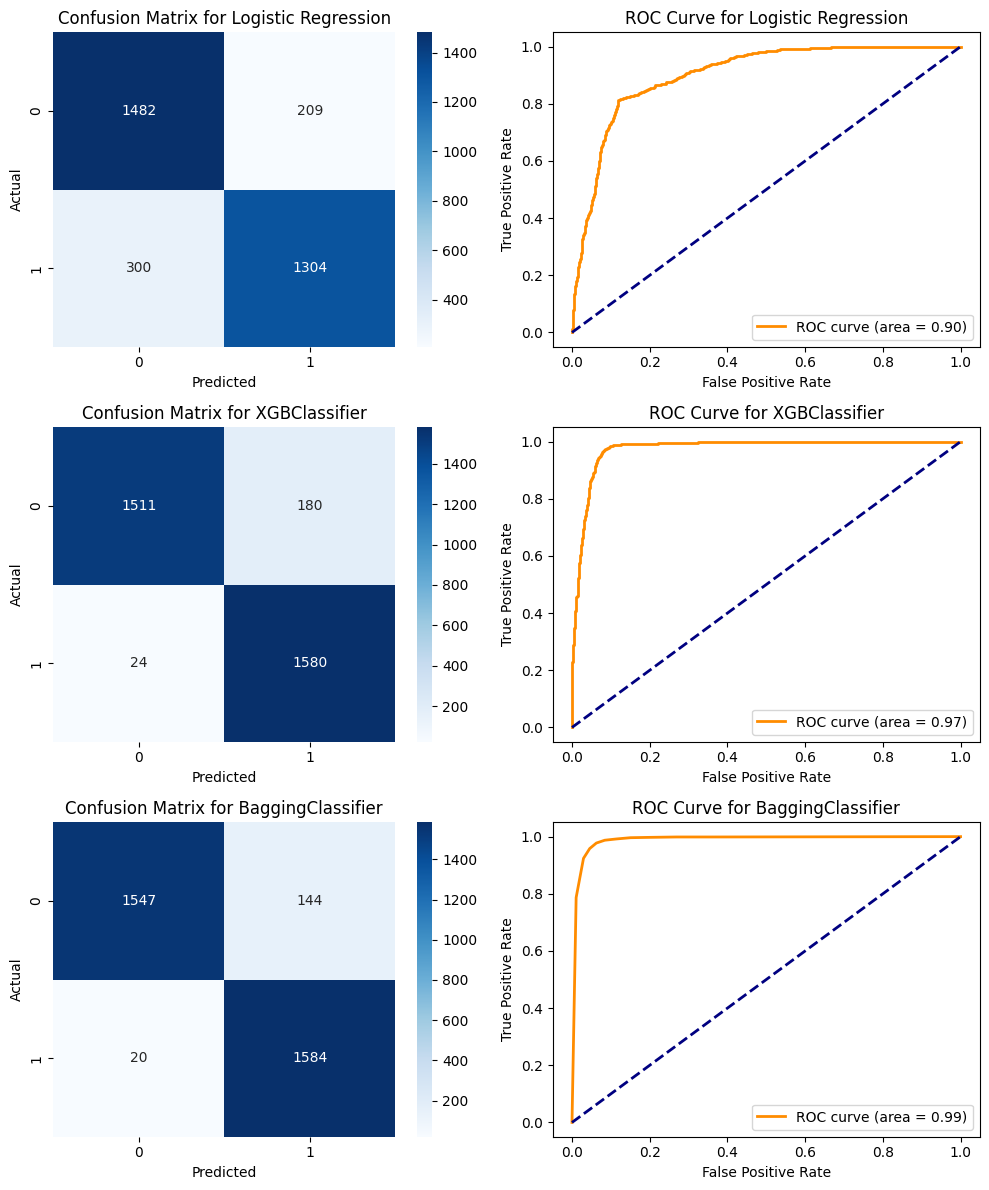

                                   Accuracy  Recall  Precision     F1
BaggingClassifier (Oversampled)       0.950   0.988      0.917  0.951
XGBClassifier (Oversampled)           0.938   0.985      0.898  0.939
Logistic Regression (Oversampled)     0.846   0.813      0.862  0.837


In [42]:
# Define the base models to be trained and evaluated
base_models = {
    "Logistic Regression": LogisticRegression(),
    "XGBClassifier": XGBClassifier(random_state=RANDOM_STATE),
    "BaggingClassifier": BaggingClassifier(random_state=RANDOM_STATE),
}

def train_and_evaluate_models_with_sampling(models: dict) -> pd.DataFrame:
    base_results = pd.DataFrame(columns=["Accuracy", "Recall", "Precision", "F1"])

    fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(10, 4 * len(models)))

    for i, (model_name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred_oversampled = model.predict(X_valid)

        accuracy_oversampled = round(accuracy_score(y_valid, y_pred_oversampled), 3)
        recall_oversampled = round(recall_score(y_valid, y_pred_oversampled), 3)
        precision_oversampled = round(precision_score(y_valid, y_pred_oversampled), 3)
        f1_oversampled = round(f1_score(y_valid, y_pred_oversampled), 3)

        base_results.loc[f"{model_name} (Oversampled)"] = [accuracy_oversampled, recall_oversampled,
                                                           precision_oversampled, f1_oversampled]

        # Confusion Matrix
        cm = confusion_matrix(y_valid, y_pred_oversampled)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 0])
        axes[i, 0].set_title(f"Confusion Matrix for {model_name}")
        axes[i, 0].set_xlabel('Predicted')
        axes[i, 0].set_ylabel('Actual')

        # ROC Curve 
        y_probs = model.predict_proba(X_valid)
        y_probs_positive = y_probs[:, 1]
        logit_roc_auc = round(roc_auc_score(y_valid, y_probs_positive), 3)

        fpr, tpr, thresholds = roc_curve(y_valid, y_probs_positive)

        axes[i, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % logit_roc_auc)
        axes[i, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[i, 1].set_xlabel('False Positive Rate')
        axes[i, 1].set_ylabel('True Positive Rate')
        axes[i, 1].set_title(f'ROC Curve for {model_name}')
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

    base_results.sort_values(by="F1", ascending=False, inplace=True)

    return base_results

base_results = train_and_evaluate_models_with_sampling(base_models)
print(base_results)


Interpretation
* The models' performance highlights varying degrees of accuracy in predicting positive cases. The BaggingClassifier and XGBClassifier showcase notably higher accuracy, recall, precision, and F1 scores, indicating superior overall performance compared to Logistic Regression. These results suggest that ensemble methods like Bagging and XGBoost exhibit stronger predictive capabilities when dealing with the oversampled dataset in this scenario.

### 6. Hyperparameter Tuning

In [14]:
def tune_and_evaluate_models(gridsearch_model: dict, param_grid: dict) -> pd.DataFrame:
    """
    Function used to tune the hyperparameters of selected models and evaluate the tuned models.

    Parameters:
        - gridsearch_model (dict): A dictionary of model names and model objects.
        - param_grid (dict): A dictionary of model names and parameter grids for hyperparameter tuning.

    Returns:
        - tuned_results (pd.DataFrame): A DataFrame containing the performance for each model, including the tuned and base models.
        - tuned_models (list): A list containing the tuned model objects.
    """
    tuned_models = []

    for model_name, model in gridsearch_model.items():
        if model_name in param_space:
            space = param_space[model_name]

            # Define the objective function for hyperparameter tuning
            def objective(params):
                model.set_params(**params)
                score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
                return -score  # Minimize the negative accuracy

            # Perform hyperparameter tuning using fmin and Trials
            trials = Trials()
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)

            # Retrieve the tuned model with the best parameters
            tuned_params = space_eval(space, best)
            tuned_model = model.set_params(**tuned_params)

            #
            tuned_models.append(tuned_model)

            # Add the tuned model to the dictionary
            base_models[f"Tuned {model_name}"] = tuned_model

    # Train and evaluate the tuned models along with the base models
    tuned_results = train_and_evaluate_models_with_sampling(base_models)


    return tuned_results, tuned_models

# Define the model to be tuned
gridsearch_model = {"XGBClassifier": XGBClassifier(random_state=RANDOM_STATE), "BaggingClassifier": BaggingClassifier(random_state=RANDOM_STATE)}

# Define the parameter grid
param_space = {
    "XGBClassifier": {
    "n_estimators": hp.uniformint("n_estimators", 50, 200, q=5),
    "max_depth": hp.uniformint("max_depth", 5, 50, q=2),
    "colsample_bytree": hp.choice("colsample_bytree", [0.5, 0.6, 0.7, 0.8, 0.9]),
    "learning_rate": hp.choice("learning_rate", [0.1, 0.01, 0.001]),
    "gamma": hp.choice("gamma", [0, 0.1, 0.2]),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 2),
    "subsample": hp.choice("subsample", [0.5, 0.7, 1]),
    "reg_alpha": hp.loguniform("reg_alpha", -5, 2),
    "reg_lambda": hp.loguniform("reg_lambda", -5, 2),
    },
    "BaggingClassifier": {
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 200]),
    'max_samples': hp.uniform('max_samples', 0.1, 1.0),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'bootstrap_features': hp.choice('bootstrap_features', [True, False]),
    }
}

# Apply the tune_and_evaluate function
tuned_model_results, tuned_models = tune_and_evaluate_models(gridsearch_model, param_space)

# Show the results of the tuned and evaluated models
print(tuned_model_results)

100%|██████████| 25/25 [00:51<00:00,  2.06s/trial, best loss: -0.9401366389467416]
                                       Accuracy  Recall  Precision     F1
Tuned BaggingClassifier (Oversampled)     0.953   0.989      0.921  0.954
BaggingClassifier (Oversampled)           0.950   0.988      0.917  0.951
Tuned XGBClassifier (Oversampled)         0.945   0.986      0.910  0.946
XGBClassifier (Oversampled)               0.938   0.985      0.898  0.939
Logistic Regression (Oversampled)         0.846   0.813      0.862  0.837


100%|██████████| 25/25 [01:20<00:00,  3.23s/trial, best loss: -0.9511384385781119]


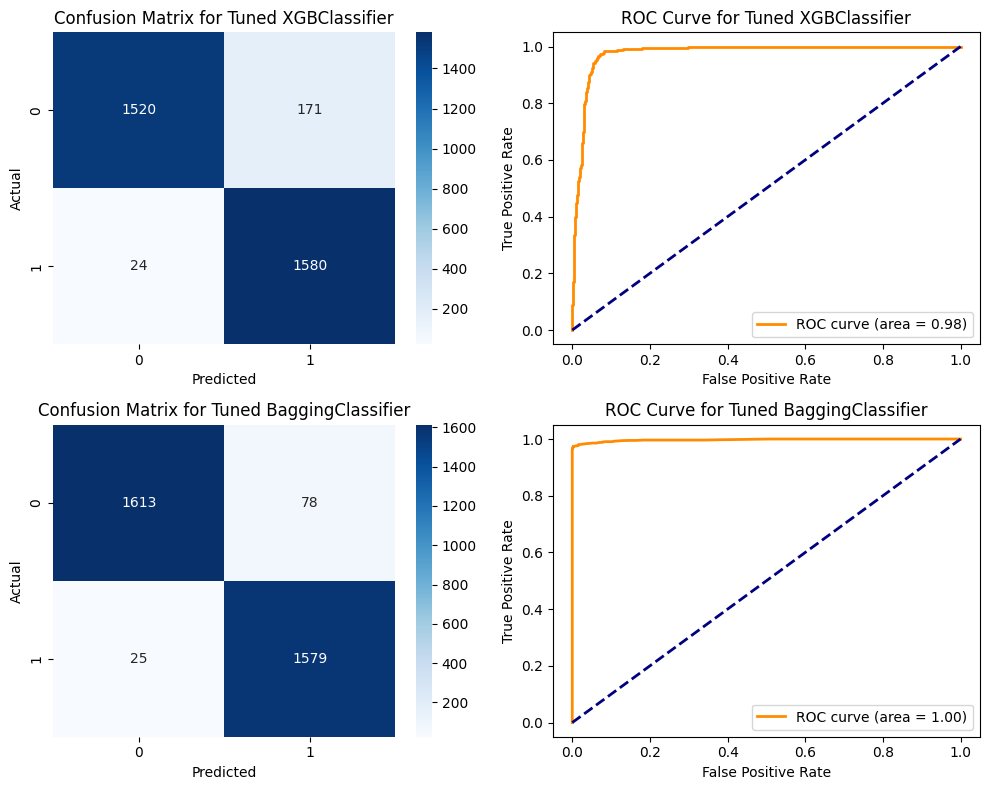

                                       Accuracy  Recall  Precision     F1
Tuned XGBClassifier (Oversampled)         0.941   0.985      0.902  0.942
Tuned BaggingClassifier (Oversampled)     0.969   0.984      0.953  0.968


In [59]:
from hyperopt import fmin, hp, tpe, Trials, space_eval
from sklearn.model_selection import cross_val_score

def tune_and_evaluate_models(gridsearch_model: dict, param_space: dict) -> pd.DataFrame:
    tuned_models = {}

    for model_name, model in gridsearch_model.items():
        if model_name in param_space:
            space = param_space[model_name]

            def objective(params):
                model.set_params(**params)
                score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
                return -score  

            trials = Trials()
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)

            tuned_params = space_eval(space, best)
            tuned_model = model.set_params(**tuned_params)
            tuned_models[f"Tuned {model_name}"] = tuned_model

    tuned_results = pd.DataFrame(columns=["Accuracy", "Recall", "Precision", "F1"])

    fig, axes = plt.subplots(nrows=len(tuned_models), ncols=2, figsize=(10, 4 * len(tuned_models)))

    for i, (model_name, model) in enumerate(tuned_models.items()):
        model.fit(X_train, y_train)
        y_pred_oversampled = model.predict(X_valid)

        accuracy_oversampled = round(accuracy_score(y_valid, y_pred_oversampled), 3)
        recall_oversampled = round(recall_score(y_valid, y_pred_oversampled), 3)
        precision_oversampled = round(precision_score(y_valid, y_pred_oversampled), 3)
        f1_oversampled = round(f1_score(y_valid, y_pred_oversampled), 3)

        tuned_results.loc[f"{model_name} (Oversampled)"] = [accuracy_oversampled, recall_oversampled,
                                                            precision_oversampled, f1_oversampled]

        # Confusion Matrix with Seaborn
        cm = confusion_matrix(y_valid, y_pred_oversampled)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 0])
        axes[i, 0].set_title(f"Confusion Matrix for {model_name}")
        axes[i, 0].set_xlabel('Predicted')
        axes[i, 0].set_ylabel('Actual')

        # ROC Curve rounded to 3 decimal places
        y_probs = model.predict_proba(X_valid)
        y_probs_positive = y_probs[:, 1]
        logit_roc_auc = round(roc_auc_score(y_valid, y_probs_positive), 3)

        fpr, tpr, thresholds = roc_curve(y_valid, y_probs_positive)

        axes[i, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % logit_roc_auc)
        axes[i, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[i, 1].set_xlabel('False Positive Rate')
        axes[i, 1].set_ylabel('True Positive Rate')
        axes[i, 1].set_title(f'ROC Curve for {model_name}')
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

    return tuned_results

# Define the model to be tuned
gridsearch_model = {"XGBClassifier": XGBClassifier(random_state=RANDOM_STATE), "BaggingClassifier": BaggingClassifier(random_state=RANDOM_STATE)}

# Define the parameter grid
param_space = {
    "XGBClassifier": {
    "n_estimators": hp.uniformint("n_estimators", 50, 200, q=5),
    "max_depth": hp.uniformint("max_depth", 5, 50, q=2),
    "colsample_bytree": hp.choice("colsample_bytree", [0.5, 0.6, 0.7, 0.8, 0.9]),
    "learning_rate": hp.choice("learning_rate", [0.1, 0.01, 0.001]),
    "gamma": hp.choice("gamma", [0, 0.1, 0.2]),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 2),
    "subsample": hp.choice("subsample", [0.5, 0.7, 1]),
    "reg_alpha": hp.loguniform("reg_alpha", -5, 2),
    "reg_lambda": hp.loguniform("reg_lambda", -5, 2),
    },
    "BaggingClassifier": {
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 200]),
    'max_samples': hp.uniform('max_samples', 0.1, 1.0),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'bootstrap_features': hp.choice('bootstrap_features', [True, False]),
    }
}

tuned_model_results = tune_and_evaluate_models(gridsearch_model, param_space)
print(tuned_model_results)

Interpretation
* Both models, post hyperparameter tuning, demonstrate enhanced performance across all metrics. The Tuned BaggingClassifier, with higher accuracy, precision, and F1 score, indicates a more robust predictive capability compared to the Tuned XGBClassifier. These results suggest that hyperparameter optimization significantly improved the models' predictive power, with BaggingClassifier showcasing the most significant enhancements.
* Considering the primary objective of an e-commerce store—to maximize orders for specific items of interest (i.e., the positive class representing purchases)—the evaluation and ranking of the models primarily depend on recall, precision, and F1-score. In this context, the XGBoost classifier exhibits a superior recall score, whereas the BaggingClassifier notably outperforms in terms of precision and F1-score."